# Machine Learning for Business and Data Visualization
## Eduardo Saldivar
## 2023077
## github: https://github.com/eduardosahe910/integratedCAML_DV.git

## 1) Discuss and explain the purpose of a recommendation system for online retail business in machine learning. Briefly compare Content and Collaborative filtering using any dataset of your choice (Datasets used in the class tutorials or exercises are not allowed to use in this CA2). Train and test machine learning models for the user-user or item-item collaborative filtering. Justify your recommendations for the considered scenario by providing a conceptual insight.

A recommendation system plays a very important role in enhacing the user experience for online retail platforms. It will helps the user by providing personalized product suggestions based on his preferences, behavior or even historical interactions with the platform.
Recommendation system also will help the user discover new broader range of products that he might like, by being exposed to a dynamic and expansive product catalog based on his preferences.
It will provide a personalized, engaging and efficient shopping experience to all of their users. The impact of a machine learning recommendation system in an online retail business extends beyond user satisfaction to influence in the business numbers such as revenues, customer retention and efficient operations.

I will continue to compare Item based and Content based reccomendation filtering ML algorithms. I will use a book's database to perform the algorithm.

## Item-Based filtering

Item based recommends items based on the preferences and the behavior of users who are similar to the target user. It is effective in capturing the user preferences and providing personalized recommendations. This recommendations are made by identifying items similar to those the user has liked or interact with. It may suffer from the "cold-start" problem when there's little or no user interaction data for a new user or item

In [1]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


books = pd.read_csv('Books.csv', low_memory = False)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


I will proceed by droping the Images columns, I consider that this columns will not make any difference in our algorithm.

In [2]:
books.drop(axis=1, labels=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True)

In [3]:
ratings = pd.read_csv('Ratings.csv', low_memory = False)
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


We can see that there is a column in common between these differents dataframes, the 'ISBN'. I will merge the two into one database so we can continue with our algorithm.

In [4]:
df = ratings.merge(books, how='inner', on='ISBN')

In [5]:
df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


Now that we had merge all into one dataframe, I need to clean it. I will drop all of the NaN in my database.

In [6]:
df.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

We have few NaN, but still I will delete them just in case.

In [7]:
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031133 entries, 0 to 1031135
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User-ID              1031133 non-null  int64 
 1   ISBN                 1031133 non-null  object
 2   Book-Rating          1031133 non-null  int64 
 3   Book-Title           1031133 non-null  object
 4   Book-Author          1031133 non-null  object
 5   Year-Of-Publication  1031133 non-null  object
 6   Publisher            1031133 non-null  object
dtypes: int64(2), object(5)
memory usage: 62.9+ MB


In [9]:
df.shape

(1031133, 7)

We see that our dataset have many rows, I will reduce the amount of rows by deleting the books that not many users read or rates. Knowing this, I will drop all of the books which have less than 250 counts.

In [10]:
# We calculate the counts of our books
book_counts = pd.DataFrame(df["Book-Title"].value_counts())

In [11]:
# Getting the books with less than 250 counts
dropped_books = book_counts[book_counts["Book-Title"] < 250].index

In [12]:
# Dropping the books
new_books = df[~df["Book-Title"].isin(dropped_books)]
new_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
62,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
63,278418,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
64,638,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
65,3363,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
66,7158,0446520802,10,The Notebook,Nicholas Sparks,1996,Warner Books


In [13]:
# I will see the mean of the ratings
ratings_mean = new_books['Book-Rating'].mean()
print(ratings_mean)

3.423071257348707


In [14]:
# making pivot table 
pivot_df = new_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values=["Book-Rating"])
pivot_df.columns = pivot_df.columns.get_level_values(1)

In [15]:
pivot_df.tail(5)

Book-Title,1984,1st to Die: A Novel,2nd Chance,A Bend in the Road,"A Child Called \It\"": One Child's Courage to Survive""",A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Map of the World,A Painted House,A Prayer for Owen Meany,A Time to Kill,A Walk to Remember,A Widow for One Year,ANGELA'S ASHES,About a Boy,Airframe,All I Really Need to Know,Along Came a Spider (Alex Cross Novels),American Gods,Angela's Ashes (MMP) : A Memoir,Angels &amp; Demons,Back Roads,Balzac and the Little Chinese Seamstress : A Novel,Bel Canto: A Novel,Black Notice,Black and Blue,Bridget Jones's Diary,Cause of Death,Chocolat,Cold Mountain : A Novel,Confessions of a Shopaholic (Summer Display Opportunity),Congo,Cradle and All,Dance upon the Air (Three Sisters Island Trilogy),Deception Point,Digital Fortress : A Thriller,Disclosure,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Dolores Claiborne,Dreamcatcher,Empire Falls,Fahrenheit 451,Fall On Your Knees (Oprah #45),Fast Food Nation: The Dark Side of the All-American Meal,Flesh and Blood,Fried Green Tomatoes at the Whistle Stop Cafe,Full House (Janet Evanovich's Full Series),Girl with a Pearl Earring,"Girl, Interrupted",Good in Bed,Hannibal,Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel),Harry Potter and the Chamber of Secrets (Book 2),Harry Potter and the Goblet of Fire (Book 4),Harry Potter and the Order of the Phoenix (Book 5),Harry Potter and the Prisoner of Azkaban (Book 3),Harry Potter and the Sorcerer's Stone (Book 1),Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),House of Sand and Fog,How to Be Good,I Know This Much Is True,Icy Sparks,Insomnia,Interview with the Vampire,Into Thin Air : A Personal Account of the Mt. Everest Disaster,Into the Wild,Isle of Dogs,Jurassic Park,Kiss the Girls,Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1),Life of Pi,Lightning,Little Altars Everywhere: A Novel,Lord of the Flies,Lucky : A Memoir,Me Talk Pretty One Day,Message in a Bottle,Midnight in the Garden of Good and Evil: A Savannah Story,Midwives: A Novel,Misery,Mystic River,Neverwhere,Nickel and Dimed: On (Not) Getting By in America,One Door Away from Heaven,One for the Money (Stephanie Plum Novels (Paperback)),Outlander,Point of Origin,Pop Goes the Weasel,Presumed Innocent,Prodigal Summer: A Novel,Red Dragon,Rising Sun,SHIPPING NEWS,STONES FROM THE RIVER,Scarlet Feather,Seabiscuit: An American Legend,Seven Up (A Stephanie Plum Novel),She's Come Undone (Oprah's Book Club (Paperback)),She's Come Undone (Oprah's Book Club),Silence of the Lambs,Skipping Christmas,Snow Falling on Cedars,Sphere,Stupid White Men ...and Other Sorry Excuses for the State of the Nation!,Summer Sisters,Suzanne's Diary for Nicholas,Tara Road,The Alchemist: A Fable About Following Your Dream,The Alienist,The Beach House,The Bean Trees,The Blind Assassin,The Bonesetter's Daughter,The Book of Ruth (Oprah's Book Club (Paperback)),The Brethren,The Bridges of Madison County,The Catcher in the Rye,The Chamber,The Cider House Rules,The Client,The Color Purple,The Da Vinci Code,The Divine Secrets of the Ya-Ya Sisterhood: A Novel,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",The Firm,The Five People You Meet in Heaven,The Girls' Guide to Hunting and Fishing,The God of Small Things,"The Golden Compass (His Dark Materials, Book 1)",The Green Mile,The Handmaid's Tale,The Hitchhiker's Guide to the Galaxy,The Hobbit : The Enchanting Prelude to The Lord of the Rings,The Horse Whisperer,The Hot Zone,The Hours: A Novel,The Hundred Secret Senses,The Joy Luck Club,The King of Torts,The Kitchen God's Wife,The Last Precinct,The Last Time They Met : A Novel,The Lost World,The Lovely Bones: A Novel,The Nanny Diaries: A Novel,The No. 1 Ladies' Detective Agency (Today Show Book Club #8),The Notebook,The Partner,The Pelican Brief,The Perfect Storm : A True Story of Men Against the Sea,The Pilot's Wife : A Novel,The Poisonwood Bible,The Poisonwood Bible

Now that I have my dataset ready, I will proceed to use the correlation method to recommend books. Correlation find relationships between variables, this will help me find patterns and also understand similarities between the books.

In [16]:
def item_based_recommender(book_name,pivot_df):
    print("Book name: "+ book_name)
    book_name_df = pivot_df[book_name]
    recommend = pivot_df.corrwith(book_name_df).sort_values(ascending=False).head(5)
    return recommend

In [17]:
book_name = pd.Series(pivot_df.columns).sample(1).values[0]
item_based_recommender(book_name,pivot_df)

Book name: Me Talk Pretty One Day


Book-Title
Me Talk Pretty One Day                                1.000000
Harry Potter and the Goblet of Fire (Book 4)          0.674391
Girl, Interrupted                                     0.522674
A Heartbreaking Work of Staggering Genius             0.495593
Harry Potter and the Order of the Phoenix (Book 5)    0.475759
dtype: float64

This is how I can recommend books based on one book of the user's choice. I will recommend the 5 books with higher correlation

## Content-Based Filtering

Conted-Based filtering recommends the items similar to those the user has shown interest in, based on the content of the items. The recommendations from this filtering are made by finding items that have similar features to those in their profile. This filtering works well for recommending items with clear, understandable features like movie genres, book genres, product attributes, etc. It may struggle to capture complex interactions that are not described by the item features. 

I will use the same dataset used in the Item-Based filtering.

The pivot table is used to create a matrix, where the rows will represent the users, the columns will represent the books and values will be the ratings of them.

In [18]:
user_id = 278843 # 278843, 278844, 278800, 26, 16
user_ratings = new_books[new_books['User-ID'] == user_id]


pivot_df = user_ratings.pivot_table(index=["User-ID"],columns=["Book-Title"],values=["Book-Rating"])
pivot_df.columns = pivot_df.columns.get_level_values(1)

It's necessary to fill the NaN values with a 0 to be able to apply cosine similarity. Cosine similarity requires numeric input. If the user hasn't rated a book, this will have a NaN value.

In [19]:
user_item_matrix  = pivot_df .fillna(0)

Now it's the time to use the cosine similarity between the books based on our matrix. Cosine similarity is a metric in collaborative filtering and other recommendation systems.

Cosine similarity is a scale-invariant, which means that it will measure the cosine of the angle between two vectors rather than the magnitude of the vectors themselves. It will focus on the direction of the vectors rather than their values.

It also have another perks, like the efficiency of this metric. With the cosine similarity is very efficienly when it deals with sparse data. The presence of many zeros in the matrix makes cosine similarity a good option for the dataset.

In [20]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

item_similarity = cosine_similarity(user_item_matrix.T)

Now that we have our similarity, I will create a list of similar cosine compare with the books that our user_id rated.

In [21]:
similar_items = list(enumerate(item_similarity[0]))

similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

top_5_similar_indices = [index for index, _ in similar_items[1:6]]

similar_books = user_item_matrix.columns[top_5_similar_indices]

Now it's time to list our recommendations.

In [22]:
print(f"Top 5 Books for User {user_id}:")
for similar_book in similar_books:
    print(similar_book)

Top 5 Books for User 278843:
Bridget Jones's Diary
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Icy Sparks
Little Altars Everywhere: A Novel
The Bonesetter's Daughter


In summary, content-based filtering relies on the features of items and the user's preferences for those features, while item-based collaborative filtering leverages user-item interaction data to find items that are similar to those the user has already shown interest in. The choice between these approaches often depends on the nature of the available data and the characteristics of the recommendation problem.

## 2) Perform Market Basket Analysis on the chosen dataset by using Apriori and FP growth algorithms. Canyou express major divergence between these models? Compare and contrast the machine learning results obtained based on both algorithms.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [24]:
groceries_df = pd.read_csv('Groceries.csv')
basket_df = pd.read_csv('basket.csv')

In [25]:
groceries_df.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


In [26]:
basket_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I will merge the two dataset so I can make some EDA with the data.

In [27]:
df = pd.concat([groceries_df, basket_df], axis =1)
df.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week,0,1,2,3,4,5,6,7,8,9,10
0,1808,2015-07-21,tropical fruit,2015,7,21,1,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2552,2015-05-01,whole milk,2015,5,1,4,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2300,2015-09-19,pip fruit,2015,9,19,5,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1187,2015-12-12,other vegetables,2015,12,12,5,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3037,2015-01-02,whole milk,2015,1,2,4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df.shape

(38765, 18)

In [29]:
df.describe()

,Member_number,year,month,day,day_of_week
count,38765.000000,38765.000000,38765.000000,38765.000000,38765.000000
mean,3003.641868,2014.528518,6.477570,15.753231,3.014498
std,1153.611031,0.499193,3.431561,8.801391,1.987669
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2002.000000,2014.000000,4.000000,8.000000,1.000000
50%,3005.000000,2015.000000,6.000000,16.000000,3.000000
75%,4007.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


We have 38,765 rows and 18 columns in our merged database. Let's go deeper and see what the members usually buy and who is the best one.

In [30]:
items = pd.DataFrame(df['itemDescription'].value_counts())
top5_items = items.sort_values(by = 'itemDescription', ascending = False).head(5).reset_index()

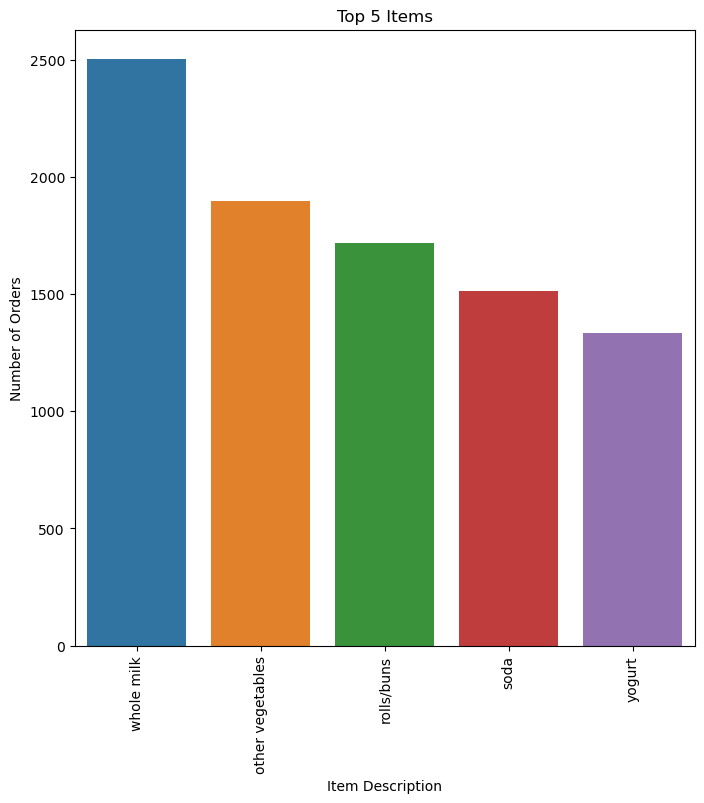

In [31]:
plt.figure(figsize=(8,8))
sns.barplot(x = 'index', y = 'itemDescription', data = top5_items)
plt.xlabel("Item Description")
plt.xticks(rotation = 90)
plt.ylabel("Number of Orders")
plt.title("Top 5 Items")
plt.show()

In [32]:
members = pd.DataFrame(df['Member_number'].value_counts())
top5_members = members.sort_values(by = 'Member_number', ascending = False).head(5).reset_index()
top5_members

,index,Member_number
0,3180,36
1,3050,33
2,2051,33
3,3737,33
4,2625,31


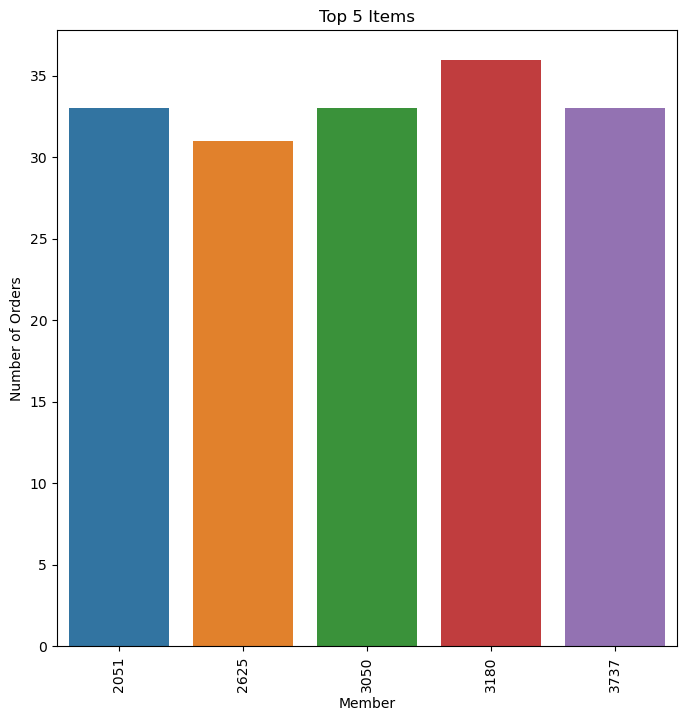

In [33]:
plt.figure(figsize=(8,8))
sns.barplot(x = 'index', y = 'Member_number', data = top5_members)
plt.xlabel("Member")
plt.xticks(rotation = 90)
plt.ylabel("Number of Orders")
plt.title("Top 5 Items")
plt.show()

I will proceed to make the market basket analysis, first I will import all the libraries.

In [34]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [35]:
basket_df.shape

(14963, 11)

In [36]:
basket_df.fillna('1', inplace = True)
basket=[]

for i in range (14963): #14963 because is the amount of rows
    basket_2 = []
    for j in range(11): #11 because is the amount of columns
        if basket_df.iloc[i,j] != '1':
            basket_2.append(basket_df.iloc[i,j])
    basket.append(basket_2)

I will use an Encoder to be able to make false/true value in my database.

In [37]:
te = TransactionEncoder()
te_basket = te.fit_transform(basket)
basket = pd.DataFrame(te_basket, columns = te.columns_)
basket.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,Fa

Here I'm transforming the true and false into 0 and 1. It's important to make these changes because the apriori method is based in a binary representation. The presence of an item in a transactions is equals to 1. The absence of an item in a transaction is equal to 0.

In [38]:
# Create and declare a method named as 'encode_units()'
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [39]:
basket = basket.applymap(encode_units)
basket.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Apriori method

Apriori Algorithm is a widely-used and well-known Association Rule algorithm and is a popular algorithm used in market basket analysis. It is also considered accurate and overtop AIS and SETM algorithms. It helps to find frequent itemsets in transactions and identifies association rules between these items.

In the following code, I will use the min_support = 0.1. What does this means?

This determines the minimum level of support that the item must have to be considered as a frequent item. The items that have the support value equal or greater than 0.1 will be included in the output.

In [40]:
frequent_itemsets = apriori(basket.astype('bool'), min_support = 0.1, use_colnames = True)
frequent_itemsets.head()

,support,itemsets
0,0.122101,(other vegetables)
1,0.110005,(rolls/buns)
2,0.157923,(whole milk)


In this data, we can appreciate the support of the items that have equal or more than 0.1. We can see that in our dataset we only have 3 items with this support. The support means, for example, that our item 'other vegetables' has a support of 0.12, which means that 12.21% of the transactions in the dataset includes this item.

What happen if we change our min_support value? Let's find out.

In [41]:
frequent_itemsets = apriori(basket.astype('bool'), min_support = 0.002, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.004010,(Instant food products)
1,0.021386,(UHT-milk)
2,0.008087,(baking powder)
3,0.033950,(beef)
4,0.021787,(berries)
...,...,...
325,0.002606,"(waffles, whole milk)"
326,0.004611,"(whipped/sour cream, whole milk)"
327,0.002941,"(yogurt, whipped/sour cream)"
328,0.003141,"(white bread, whole milk)"


We see that more values appears when we lower our min_support because the limit is not 0.1 anymore.

Now having this min_support, we are able to change some rules to be able to see how our apriori algorithm works. We can modify our rules and form different datasets according to this ones. Here is an example:

In [42]:
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1) 
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(berries),(other vegetables),0.021787,0.122101,0.002673,0.122699,1.004899,0.000013,1.000682,0.004984
1,(other vegetables),(berries),0.122101,0.021787,0.002673,0.021894,1.004899,0.000013,1.000109,0.005553
2,(sausage),(bottled beer),0.060349,0.045312,0.003342,0.055371,1.222000,0.000607,1.010649,0.193337
3,(bottled beer),(sausage),0.045312,0.060349,0.003342,0.073746,1.222000,0.000607,1.014464,0.190292
4,(brown bread),(canned beer),0.037626,0.046916,0.002406,0.063943,1.362937,0.000641,1.018191,0.276701


My rules dataset means that it will bring all my items which 'lift' is equal or greater than 1. 'Lift' metric measures how much more likely the consequent is to be bought. In this case, when a customer buys 'other vegetables' it have a lift equals more than 1, this means is a positive lift and is likely that the customer will buy 'berries' as well.

Now I will sorted my data by ascending 'lift', so it will bring me my items which is more likely to buy together.

In [43]:
sorted_rules = rules.sort_values(by ="lift", ascending = False)
sorted_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
12,(curd),(sausage),0.033683,0.060349,0.002941,0.087302,1.446615,0.000908,1.029531,0.319493
13,(sausage),(curd),0.060349,0.033683,0.002941,0.048726,1.446615,0.000908,1.015814,0.328559
4,(brown bread),(canned beer),0.037626,0.046916,0.002406,0.063943,1.362937,0.000641,1.018191,0.276701
5,(canned beer),(brown bread),0.046916,0.037626,0.002406,0.051282,1.362937,0.000641,1.014394,0.279398
21,(frozen vegetables),(sausage),0.028002,0.060349,0.002072,0.073986,1.225966,0.000382,1.014726,0.189627
20,(sausage),(frozen vegetables),0.060349,0.028002,0.002072,0.034330,1.225966,0.000382,1.006553,0.196155
2,(sausage),(bottled beer),0.060349,0.045312,0.003342,0.055371,1.222000,0.000607,1.010649,0.193337
3,(bottled beer),(sausage),0.045312,0.060349,0.003342,0.073746,1.222000,0.000607,1.014464,0.190292
15,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420,0.108146
14,(other vegetables),(frankfurter),0.122101,0.037760,0.005146,0.042146,1.116150,0.000536,1.004579,0.118536


As we can see, our items with more lift are ['curd, sausage'], ['brown bread', 'canned beer'], ['sausage', 'frozen vegetables']

There are other rules we can apply:

Support: This column shows the support of the combined antecedent and consequent itemsets. It represents the proportion of transactions that contain both the antecedent and the consequent.

Confidence: Confidence measures how often the rule has been found to be true. It is the ratio of the support for the combined itemsets to the support for the antecedent. For example, a confidence of 0.1 means that, in 10% of the cases where the antecedent occurs, the consequent also occurs.

Leverage: Leverage measures the difference in the frequency of the antecedent and consequent appearing together and what would be expected if they were independent. Positive leverage indicates that the items appear together more often than expected.

Conviction: Conviction is a measure of how much the consequent relies on the antecedent. A high conviction value indicates that the consequent is highly dependent on the antecedent.

Zhangs_metric: Zhang's metric is another measure of association strength. It takes into account the support of the combined itemsets, the support of the antecedent, and the support of the consequent.

FP-growth algorithm

The FP Growth algorithm in data mining is a frequent itemset mining algorithm used to discover frequently occurring patterns in large datasets. It generates frequent itemsets efficiently by constructing an FP-Tree data structure that represents the input dataset and mining the tree for recurring patterns.

In [44]:
from mlxtend.frequent_patterns import fpgrowth

# Evaluate the frequent item rules for fpgrowth function
frequent_itemsets_fp = fpgrowth(basket.astype('bool'), min_support = 0.002, use_colnames = True)

frequent_itemsets_fp

,support,itemsets
0,0.157923,(whole milk)
1,0.051728,(pastry)
2,0.018780,(salty snack)
3,0.085879,(yogurt)
4,0.060349,(sausage)
...,...,...
325,0.003943,"(other vegetables, pork)"
326,0.003074,"(yogurt, pork)"
327,0.003408,"(pork, rolls/buns)"
328,0.003007,"(pork, soda)"


With the FP growth, we can see that the item 'other vegetables' is not the one with more support. In this case it's 'whole milk'. Which means that 15.79% of the transactions in the dataset includes this item with the FP growth.

In [45]:
from mlxtend.frequent_patterns import association_rules

# Display the rules due to fp-growth algorithm
rules_fp = association_rules(frequent_itemsets_fp, metric = "lift", min_threshold = 1)

rules_fp.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(sausage),(pastry),0.060349,0.051728,0.003208,0.053156,1.027617,0.000086,1.001509,0.028601
1,(pastry),(sausage),0.051728,0.060349,0.003208,0.062016,1.027617,0.000086,1.001777,0.028341
2,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,0.000565,1.007049,0.107508
3,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,0.000565,1.010345,0.104587
4,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,0.000088,1.001613,0.015702


In [46]:
sorted_rules_fp = rules_fp.sort_values(by ="lift", ascending = False)
sorted_rules_fp.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
8,(curd),(sausage),0.033683,0.060349,0.002941,0.087302,1.446615,0.000908,1.029531,0.319493
9,(sausage),(curd),0.060349,0.033683,0.002941,0.048726,1.446615,0.000908,1.015814,0.328559
26,(brown bread),(canned beer),0.037626,0.046916,0.002406,0.063943,1.362937,0.000641,1.018191,0.276701
27,(canned beer),(brown bread),0.046916,0.037626,0.002406,0.051282,1.362937,0.000641,1.014394,0.279398
10,(sausage),(frozen vegetables),0.060349,0.028002,0.002072,0.034330,1.225966,0.000382,1.006553,0.196155
11,(frozen vegetables),(sausage),0.028002,0.060349,0.002072,0.073986,1.225966,0.000382,1.014726,0.189627
21,(bottled beer),(sausage),0.045312,0.060349,0.003342,0.073746,1.222000,0.000607,1.014464,0.190292
20,(sausage),(bottled beer),0.060349,0.045312,0.003342,0.055371,1.222000,0.000607,1.010649,0.193337
7,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420,0.108146
6,(other vegetables),(frankfurter),0.122101,0.037760,0.005146,0.042146,1.116150,0.000536,1.004579,0.118536


After doing all of this algorithms, I can show some differences between these two.

Apriori algorithm generates itemsets by joining and pruning based on the frequent itemsets of the iteration. This means that need to make multiples iterations in the data. FP-Growth algorithm creates a structure called the FP-Tree. This structure is used to mine the frequent itemsets. FP-Growth doesn't need to iterates a lot of times in the data as the apriori.

The multiple iterations in the dataset makes Apriori algorithm to use more memory usage, especially when it deals with large amount of itemsets. FP-Growth is more memory-efficient thanks to its data structure (FP-Tree).

If you want to decide which algorithm use, you first might want to check your computer capacity. The choice depends on the specific characteristics of the dataset AND the pc available resources.

Note: The dashboard of the instruction #3 is in the file: Eduardo Saldivar_Dashboard.ipynb

## References

Stack Overflow. (n.d.). What’s difference between item-based and content-based collaborative filtering? [online] Available at: https://stackoverflow.com/questions/16372191/whats-difference-between-item-based-and-content-based-collaborative-filtering 

PYTHON CHARTS | The definitive Python data visualization site. (2022). Bar chart in plotly. [online] Available at: https://python-charts.com/ranking/bar-chart-plotly/#:~:text=If%20you%20want%20to%20change

GitHub. (n.d.). Indexing pandas data frame with set will be deprecated · Issue #7 · aertslab/pycistarget. [online] Available at: https://github.com/aertslab/pycistarget/issues/7

docs.rapidminer.com. (n.d.). FP-Growth - RapidMiner Documentation. [online] Available at: https://docs.rapidminer.com/latest/studio/operators/modeling/associations/fp_growth.html#:~:text=The%20FP%2DGrowth%20algorithm%20is

Jodha, R. (2023). FP Growth Algorithm in Data Mining. [online] Scaler Topics. Available at: https://www.scaler.com/topics/data-mining-tutorial/fp-growth-in-data-mining/ 

Lim, Y. (2022). Data Mining: Market Basket Analysis with Apriori Algorithm. [online] Medium. Available at: https://towardsdatascience.com/data-mining-market-basket-analysis-with-apriori-algorithm-970ff256a92c

Toptal Design Blog. (n.d.). Dashboard Design - Considerations and Best Practices | Toptal®. [online] Available at: https://www.toptal.com/designers/data-visualization/dashboard-design-best-practices#:~:text=Great%20dashboards%20are%20clear%2C%20intuitive.

dash.plotly.com. (n.d.). Dash Documentation & User Guide | Plotly. [online] Available at: https://dash.plotly.com/.

www.youtube.com. (n.d.). Dropdown Selector- Python Dash Plotly. [online] Available at: https://www.youtube.com/watch?v=UYH_dNSX1DM&list=PLh3I780jNsiSvpGtPucq4yusBXVt3SL2Q 

www.youtube.com. (n.d.). Introduction to Plotly Dash Web Application Development Framework | Plotly Dash Tutorial Part -1. [online] Available at: https://www.youtube.com/watch?v=Ma8tS4p27JI&list=PLH6mU1kedUy8fCzkTTJlwsf2EnV_UvOV-